## Exercise:

Combine best N features from Uni+Bigram+Negation  
together with w2v and glove feature  
apply SVM/LogRegress(N feateures+w2v+glove)

In [1]:
##prepare dataset
from os import getcwd, chdir
fpath = getcwd()
print(fpath)
# Change your path here
chdir(fpath)


d:\Documents\NUS-ISS\EBA5004 GC Specialized Practical Language Processing (PT)\NMSM\Day 2\workshop


In [2]:
###################################################
#Data Preparation
###################################################
import pickle as pk
trainset = pk.load(open(fpath+"\\Data\\trainset.pk", "rb"))
testset = pk.load(open(fpath+"\\Data\\testset.pk", "rb"))

X_train = [t[0] for t in trainset]
X_test = [t[0] for t in testset]

X = X_train + X_test

Y_train = [t[1] for t in trainset]
Y_test = [t[1] for t in testset]

y = Y_train + Y_test

X, y = np.array(X), np.array(y)


NameError: name 'np' is not defined

### Get the Kbest feature from Ngrams+Negation

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)


In [ ]:
#ADD Features - Negation
import re


def nega_tag(text):
    transformed = re.sub(r"\b(?:never|nothing|nowhere|noone|none|not|haven't|hasn't|hasnt|hadn't|hadnt|can't|cant|couldn't|couldnt|shouldn't|shouldnt|won't|wont|wouldn't|wouldnt|don't|dont|doesn't|doesnt|didn't|didnt|isnt|isn't|aren't|arent|aint|ain't|hardly|seldom)\b[\w\s]+[^\w\s]", lambda match: re.sub(
        r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), text, flags=re.IGNORECASE)
    return(transformed)


# Create a training list which will now contain reviews with Negatively tagged words and their labels
train_set_nega = []

# Append elements to the list
for doc in trainset:
    trans = nega_tag(doc[0])
    lab = doc[1]
    train_set_nega.append([trans, lab])

print(train_set_nega[18])

# Create a testing list which will now contain reviews with Negatively tagged words and their labels
test_set_nega = []

# Append elements to the list
for doc in testset:
    trans = nega_tag(doc[0])
    lab = doc[1]
    test_set_nega.append([trans, lab])


print(test_set_nega[18])


["another restaurant kevin and i frequent when we are out and about in chandler. good prices, and the food is consistently good. i love the vegetarian pizza. in fact, their pizzas are all pretty good. kevin got the nachos last time, which he enjoyed. i am no beer critic, since i pretty much hate it, but since it is a brewery, i can only assume the beer is up to par. the service is also good, and i love how lively it always is, even at ten on a monday night. i always walk away satisfied and with the confidence that i have not NEG_just NEG_wasted NEG_my NEG_money NEG_on NEG_mediocre NEG_food NEG_and NEG_drinks. thanks for being a friend, bj's!", 1]
["this is my go-to chinese takeout joint.  i live around the corner from ho-ho cherry house in elizabeth, but choose to drive the extra mile or so down the street to come to fortune cookie.\n\n\n\ni have never NEG_had NEG_a NEG_bad NEG_experience NEG_and NEG_have NEG_ordered NEG_at NEG_least NEG_15+ meals from here.  they are quick, always get

In [ ]:
#Redo - Preprocessing
# seperate the text with labels

X_nega_train = [t[0] for t in train_set_nega]
X_nega_test = [t[0] for t in test_set_nega]

Y_nega_train = [t[1] for t in train_set_nega]
Y_nega_test = [t[1] for t in test_set_nega]

#Vectorizer the sentences using Tfidf vale
#Make sure test data should be transformed using vectorizer learned from training data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
train_nega_vectors = vectorizer.fit_transform(X_nega_train)
test_nega_vectors = vectorizer.transform(X_nega_test)

# bigger feature set
print(train_vectors.shape)
print(test_vectors.shape)

print(train_nega_vectors.shape)
print(test_nega_vectors.shape)


(17933, 549262)
(3797, 549262)
(17933, 610107)
(3797, 610107)


In [ ]:
ch21 = SelectKBest(chi2, k=100)
train_Kbest = ch21.fit_transform(train_nega_vectors, Y_nega_train)
test_Kbest = ch21.transform(test_nega_vectors)
train_Kbest.shape


(17933, 100)

### define the embedding

In [ ]:
import numpy as np
encoding = "utf-8"
GLOVE_6B_100D_PATH = fpath+"\\Data\\glove.6B.100d.txt"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:], dtype=np.float32)
            for line in lines}


In [ ]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our data set

glove_small = {}
all_words = set(w for words in X for w in words)

print(len(all_words))

with open(GLOVE_6B_100D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums = np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums


125


In [ ]:
#MeanEmbeddingVectorizer define the way to represent docs using word vectors

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec) > 0:
            self.dim = len(word2vec[next(iter(glove_small))])
            #self.dim=len(word2vec["and"])
        else:
            self.dim = 0

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [ ]:
from gensim.models.word2vec import Word2Vec
#Prepare word embeddings by training from dataset
model = Word2Vec(X, vector_size=100, window=5, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index_to_key, model.wv.vectors)}


In [ ]:
w2v_Embedding = MeanEmbeddingVectorizer(w2v)
glove_Embedding = MeanEmbeddingVectorizer(glove_small)

### grab w2v feature

In [ ]:
X_w2v_train = w2v_Embedding.transform(X_train)
print(X_w2v_train.shape)
X_w2v_test = w2v_Embedding.transform(X_test)
print(X_w2v_test.shape)


(17933, 100)
(3797, 100)


### grab glove feature

In [ ]:
X_glove_train = glove_Embedding.transform(X_train)
print(X_glove_train.shape)
X_glove_test = glove_Embedding.transform(X_test)
print(X_glove_test.shape)


(17933, 100)
(3797, 100)


In [ ]:
print(X_w2v_train.shape, X_glove_train.shape, train_Kbest.shape)
print(type(X_w2v_train), type(X_glove_train), type(train_Kbest))


(17933, 100) (17933, 100) (17933, 100)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>


### combine the feature set

In [ ]:
final_train = np.c_[X_w2v_train, X_glove_train, train_Kbest.toarray()]
print(final_train.shape)
final_test = np.c_[X_w2v_test, X_glove_test, test_Kbest.toarray()]
print(final_test.shape)


(17933, 300)
(3797, 300)


### Train the Classifiers

In [ ]:
from sklearn.svm import LinearSVC
model_svm = LinearSVC(C=1.0)
sv = model_svm.fit(final_train, Y_train)
predSVM = sv.predict(final_test)
pred = list(predSVM)

### Evaluate on the features from of test data

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(Y_test, pred))
print(np.mean(predSVM == Y_test))
print(metrics.classification_report(Y_test, pred))


[[1627  170]
 [ 679 1321]]
0.7764024229654991
              precision    recall  f1-score   support

          -1       0.71      0.91      0.79      1797
           1       0.89      0.66      0.76      2000

    accuracy                           0.78      3797
   macro avg       0.80      0.78      0.77      3797
weighted avg       0.80      0.78      0.77      3797



## Compare with individual models

### unigram, bigram, negation vectors model

In [ ]:
model_svm_Kbest = LinearSVC(C=1.0)
sv_Kbest = model_svm_Kbest.fit(train_Kbest, Y_train)
predSVM_Kbest = sv_Kbest.predict(test_Kbest)
pred_Kbest = list(predSVM_Kbest)
print(metrics.confusion_matrix(Y_test, pred_Kbest))
print(np.mean(predSVM_Kbest == Y_test))
print(metrics.classification_report(Y_test, pred_Kbest))


[[1567  230]
 [ 485 1515]]
0.8116934421912035
              precision    recall  f1-score   support

          -1       0.76      0.87      0.81      1797
           1       0.87      0.76      0.81      2000

    accuracy                           0.81      3797
   macro avg       0.82      0.81      0.81      3797
weighted avg       0.82      0.81      0.81      3797



### word 2 vec

In [ ]:
model_svm_w2v = LinearSVC(C=1.0)
sv_w2v = model_svm_w2v.fit(X_w2v_train, Y_train)
predSVM_w2v = sv_w2v.predict(X_w2v_test)
pred_w2v = list(predSVM_w2v)
print(metrics.confusion_matrix(Y_test, pred_w2v))
print(np.mean(predSVM_w2v == Y_test))
print(metrics.classification_report(Y_test, pred_w2v))

[[1641  156]
 [1398  602]]
0.5907295233078746
              precision    recall  f1-score   support

          -1       0.54      0.91      0.68      1797
           1       0.79      0.30      0.44      2000

    accuracy                           0.59      3797
   macro avg       0.67      0.61      0.56      3797
weighted avg       0.67      0.59      0.55      3797



### Glove

In [ ]:
model_svm_glove = LinearSVC(C=1.0)
sv_glove = model_svm_glove.fit(X_glove_train, Y_train)
predSVM_glove = sv_glove.predict(X_glove_test)
pred_glove = list(predSVM_glove)
print(metrics.confusion_matrix(Y_test, pred_glove))
print(np.mean(predSVM_glove == Y_test))
print(metrics.classification_report(Y_test, pred_glove))


[[1470  327]
 [ 966 1034]]
0.6594680010534633
              precision    recall  f1-score   support

          -1       0.60      0.82      0.69      1797
           1       0.76      0.52      0.62      2000

    accuracy                           0.66      3797
   macro avg       0.68      0.67      0.65      3797
weighted avg       0.69      0.66      0.65      3797



### benchmark all the models

[Text(0, 0.5, 'accuracy')]

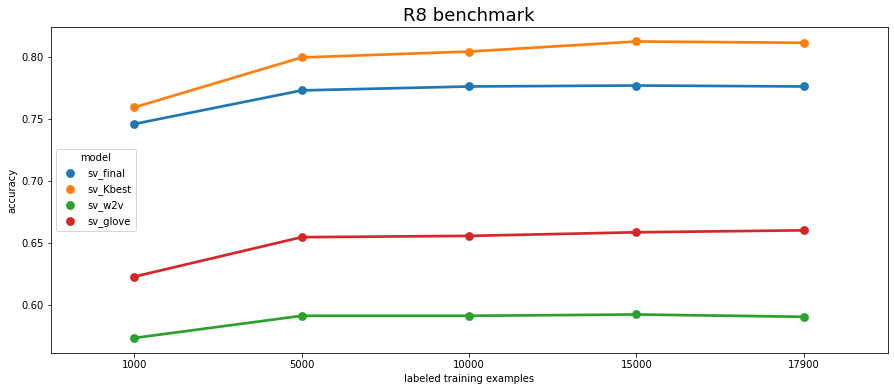

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

all_models_train_test = [
    ("sv_final", sv, final_train, final_test),
    ("sv_Kbest", sv_Kbest, train_Kbest.toarray(), test_Kbest.toarray()),
    ("sv_w2v", sv_w2v, X_w2v_train, X_w2v_test),
    ("sv_glove", sv_glove, X_glove_train, X_glove_test)
]

##how the ranking depends on the amount of training data

def benchmark(model, X, y, n, X_test, y_test):
    scores = []
    sss = StratifiedShuffleSplit(n_splits=5, train_size=n, test_size=len(y)-n)

    for train, test in sss.split(X, y):
        X_train = X[train]
        y_train = y[train]
        scores.append(accuracy_score(
            model.fit(X_train, y_train).predict(X_test), y_test))
        break
    return np.mean(scores)


train_sizes = [1000, 5000, 10000, 15000, 17900]
table = []
for name, model, X_train, X_test in all_models_train_test:
    for n in train_sizes:
        table.append({'model': name,
                      'accuracy': benchmark(model, np.array(X_train), np.array(Y_train), n, X_test, Y_test),
                      'train_size': n})
df = pd.DataFrame(table)

plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model',
                    data=df[df.model.map(lambda x: x in ["sv_final", "sv_Kbest", "sv_w2v", "sv_glove"])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")
